In [24]:
import os
import sys
import matplotlib.pyplot as plt
import matplotlib.lines as mlines
import numpy as np
import pickle
import torch
import astropy.units as u
import pandas as pd

from astropy.io import fits, ascii
from astropy.coordinates import SkyCoord, Angle, concatenate
from neural_net import normalize_arr, get_model, CustomLoss, resume
from sklearn.impute import KNNImputer

from preprocessing.preprocessing import ab_mag_to_flux
ab_magerr_to_ferr = lambda sigma_m, f: np.abs(f * np.log(10) * (sigma_m / 2.5))  # transformation on the error of a magnitude turned into flux

import matplotlib as mpl
plt.rc('text', usetex=True)

mpl.rcParams['font.family'] = 'serif'
mpl.rcParams['font.serif'] = 'cmr10'  # Computer Modern Roman
mpl.rcParams['font.size'] = 12  # Adjust the font size as needed

PATH_TO_CLEAN_DATA = '/Users/adamboesky/Research/ay98/clean_data'

# Clean the BTS SNe coordinates file for Panstarrs host association

In [25]:
bts_df = pd.read_csv('/Users/adamboesky/Research/ay98/clean_data/bts_sne.csv')
bts_df

,ZTFID,IAUID,RA,Dec,peakt,peakfilt,peakmag,peakabs,duration,rise,fade,type,redshift,b,A_V
0,ZTF17aaaeqms,AT2023jkf,01:19:13.43,+31:46:26.1,2102.97,r,17.5839,-,18.001,12.004,5.997,-,-,-30.726791,0.205
1,ZTF17aaajowi,-,11:47:44.37,+14:34:10.4,1362.73,r,18.9963,-,>5.611,2.651,>2.96,-,-,70.564727,0.127
2,ZTF17aaazdba,AT2019azh,08:13:16.95,+22:38:53.9,561.73,g,15.2769,-19.76,66.42,24.318,42.102,TDE,0.022,27.562336,0.122
3,ZTF17aabtvsy,SN2022yei,10:35:32.09,+37:38:59.0,1870.99,r,18.0303,-19.41,>34.229,>6.01,28.219,SN Ia,0.06922,59.641962,0.053
4,ZTF17aabwkio,AT2019sio,07:39:53.05,-02:58:50.6,765.01,g,18.1673,-,5.615,2.657,2.958,-,-,9.367699,0.306
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
7613,ZTF24aadryxf,AT2024bdy,08:11:39.37,-06:12:46.5,2341.84,g,18.9243,-,>18.07,>2.05,>16.02,-,-,14.717259,0.154
7614,ZTF24aaecshg,AT2024asp,10:27:12.30,+31:57:30.4,2341.85,g,18.9854,-,>12.96,>0,>12.96,-,-,58.406619,0.048
7615,ZTF24aaecxwe,AT2024bho,11:18:48.75,+78:04:57.2,2341.90,r,18.8290,-,>10.704,>0.12,10.584,-,-,37.961778,0.074
7616,ZTF24aaedncr,SN2005X,12:24:00.71,+07:46:39.2,2352.91,r,18.4054,-,>15.13,>11.06,>4.07,-,-,69.586749,0.069


In [26]:
ras = []
decs = []

for ra, dec in zip(bts_df['RA'], bts_df['Dec']):
    ra_ang = Angle(ra.split(',')[0], unit='hourangle')
    dec_ang = Angle(f'{dec.split(",")[0]} degrees')
    ras.append(ra_ang.degree)
    decs.append(dec_ang.degree)

In [4]:
bts_df['ra_deg'] = ras
bts_df['dec_deg'] = decs
bts_df

,ZTFID,IAUID,RA,Dec,peakt,peakfilt,peakmag,peakabs,duration,rise,fade,type,redshift,b,A_V,ra_deg,dec_deg
0,ZTF17aaaeqms,AT2023jkf,01:19:13.43,+31:46:26.1,2102.97,r,17.5839,-,18.001,12.004,5.997,-,-,-30.726791,0.205,19.805958,31.773917
1,ZTF17aaajowi,-,11:47:44.37,+14:34:10.4,1362.73,r,18.9963,-,>5.611,2.651,>2.96,-,-,70.564727,0.127,176.934875,14.569556
2,ZTF17aaazdba,AT2019azh,08:13:16.95,+22:38:53.9,561.73,g,15.2769,-19.76,66.42,24.318,42.102,TDE,0.022,27.562336,0.122,123.320625,22.648306
3,ZTF17aabtvsy,SN2022yei,10:35:32.09,+37:38:59.0,1870.99,r,18.0303,-19.41,>34.229,>6.01,28.219,SN Ia,0.06922,59.641962,0.053,158.883708,37.649722
4,ZTF17aabwkio,AT2019sio,07:39:53.05,-02:58:50.6,765.01,g,18.1673,-,5.615,2.657,2.958,-,-,9.367699,0.306,114.971042,-2.980722
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
7613,ZTF24aadryxf,AT2024bdy,08:11:39.37,-06:12:46.5,2341.84,g,18.9243,-,>18.07,>2.05,>16.02,-,-,14.717259,0.154,122.914042,-6.212917
7614,ZTF24aaecshg,AT2024asp,10:27:12.30,+31:57:30.4,2341.85,g,18.9854,-,>12.96,>0,>12.96,-,-,58.406619,0.048,156.801250,31.958444
7615,ZTF24aaecxwe,AT2024bho,11:18:48.75,+78:04:57.2,2341.90,r,18.8290,-,>10.704,>0.12,10.584,-,-,37.961778,0.074,169.703125,78.082556
7616,ZTF24aaedncr,SN2005X,12:24:00.71,+07:46:39.2,2352.91,r,18.4054,-,>15.13,>11.06,>4.07,-,-,69.586749,0.069,186.002958,7.777556


In [5]:
# Drop everything with no redshift
bts_clean_df = bts_df[bts_df['redshift'] != '-']
bts_clean_df = bts_clean_df[~pd.isnull(bts_clean_df['redshift'])]
bts_clean_df.reset_index(inplace=True, drop=True)
bts_clean_df

,ZTFID,IAUID,RA,Dec,peakt,peakfilt,peakmag,peakabs,duration,rise,fade,type,redshift,b,A_V,ra_deg,dec_deg
0,ZTF17aaazdba,AT2019azh,08:13:16.95,+22:38:53.9,561.73,g,15.2769,-19.76,66.42,24.318,42.102,TDE,0.022,27.562336,0.122,123.320625,22.648306
1,ZTF17aabtvsy,SN2022yei,10:35:32.09,+37:38:59.0,1870.99,r,18.0303,-19.41,>34.229,>6.01,28.219,SN Ia,0.06922,59.641962,0.053,158.883708,37.649722
2,ZTF17aacldgo,SN2022zxv,03:09:24.35,-04:53:39.2,1897.75,g,18.7979,-18.91,>8.87,>3.85,>5.02,SN Ia,0.072,-50.332472,0.183,47.351458,-4.894222
3,ZTF17aadlxmv,SN2020adv,08:29:47.59,+33:54:22.8,879.69,g,17.9475,-19.34,25.146,10.951,14.195,SN Ia,0.062,34.174702,0.106,127.448292,33.906333
4,ZTF18aaaibml,SN2020buc,10:08:31.27,+09:14:23.0,909.80,r,18.2606,-17.70,69.73,27.302,42.428,SN II,0.0348,47.637802,0.092,152.130292,9.239722
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
5337,ZTF24aaczgax,SN2024anc,10:58:15.99,+23:41:37.3,2341.77,g,17.2317,-17.64,19.703,10.28,9.423,SN II,0.02128,64.269422,0.046,164.566625,23.693694
5338,ZTF24aadauao,SN2024alp,01:59:32.67,+41:09:13.2,2340.62,g,17.8560,-19.40,>22.765,7.735,>15.03,SN Ia,0.05859,-19.917448,0.182,29.886125,41.153667
5339,ZTF24aadkwni,AT2024aul,10:21:53.23,+00:17:44.2,2339.81,r,17.5125,-17.44,>21.96,>3.89,>18.07,SN II,0.0215,45.192542,0.134,155.471792,0.295611
5340,ZTF24aadkwol,SN2024apt,10:25:36.87,-02:12:39.2,2354.83,g,15.4292,-19.23,31.42,17.427,13.993,SN Ia,0.01850,44.243280,0.124,156.403625,-2.210889


In [7]:
# Write to csv
bts_clean_df.to_csv('/Users/adamboesky/Research/ay98/clean_data/bts_sne_clean.csv')

# Load YSE and BTS data

In [27]:
# BTS
bts_hosts = ascii.read('/Users/adamboesky/Research/ay98/clean_data/bts_hosts.ecsv')
bts_df = bts_hosts.to_pandas()

# YSE
yse_hosts = ascii.read('/Users/adamboesky/Research/ay98/clean_data/yse_hosts.ecsv')
yse_df = yse_hosts.to_pandas()
print('BTS keys: ', bts_df.columns)
print('YSE keys: ', yse_df.columns)

BTS keys:  Index(['objID_3pi', 'raStack_3pi', 'decStack_3pi', 'primaryDetection_3pi',
       'gKronMag_3pi', 'rKronMag_3pi', 'iKronMag_3pi', 'zKronMag_3pi',
       'yKronMag_3pi', 'gKronMagErr_3pi', 'rKronMagErr_3pi', 'iKronMagErr_3pi',
       'zKronMagErr_3pi', 'yKronMagErr_3pi', 'ps_score_3pi', 'SN_ra', 'SN_dec',
       'sn_class', 'sn_redshift', 'ZTFID'],
      dtype='object')
YSE keys:  Index(['objID_3pi', 'raStack_3pi', 'decStack_3pi', 'primaryDetection_3pi',
       'gKronMag_3pi', 'rKronMag_3pi', 'iKronMag_3pi', 'zKronMag_3pi',
       'yKronMag_3pi', 'gKronMagErr_3pi', 'rKronMagErr_3pi', 'iKronMagErr_3pi',
       'zKronMagErr_3pi', 'yKronMagErr_3pi', 'ps_score_3pi', 'SN_ra', 'SN_dec',
       'sn_class', 'sn_redshift'],
      dtype='object')


In [28]:
# yse_hosts['gKronMagErr_3pi'][np.array(yse_hosts['gKronMagErr_3pi']).astype(float) == 0]
np.isnan(np.array(yse_hosts['gKronMagErr_3pi']).astype(float)),np.sum(np.isnan(np.array(yse_hosts['gKronMagErr_3pi']).astype(float))) / len(yse_hosts)

(array([False, False, False, False, False, False, False, False, False,
        False, False, False, False, False, False, False, False, False,
         True, False, False, False, False, False, False, False, False,
        False, False, False, False, False, False, False, False, False,
        False, False, False, False, False, False, False, False, False,
        False, False, False, False, False,  True, False, False, False,
        False, False, False, False, False, False, False, False, False,
        False, False, False, False, False, False, False, False, False,
        False, False, False, False, False, False, False, False, False,
        False, False, False,  True, False, False, False, False,  True,
        False, False, False, False, False, False, False, False, False,
        False,  True, False, False, False, False, False, False, False,
        False, False, False, False, False, False, False, False, False,
        False, False, False, False,  True, False, False, False, False,
      

In [29]:
# Function to calculate angular separation
def angular_separation(ra1, dec1, ra2, dec2):
    coord1 = SkyCoord(ra1, dec1, unit='deg')
    coord2 = SkyCoord(ra2, dec2, unit='deg')
    return coord1.separation(coord2).arcsec

def propocess_tab(table: ascii.Tab) -> pd.DataFrame:

    # Make and format a pd dataframe
    df: pd.DataFrame = table.to_pandas()
    column_types = {col: float for col in df.columns[:-2]}
    column_types[df.columns[-2]] = str
    column_types[df.columns[-1]] = float
    df = df.astype(column_types)
    df.replace('nan', np.nan, inplace=True)

    # The columns of grizy mags
    sed_cols = ['gKronMag_3pi','rKronMag_3pi','iKronMag_3pi','zKronMag_3pi','yKronMag_3pi']

    # Drop rows where the specified columns have more than 4 NaN values
    orig_len = len(df)
    df = df.dropna(thresh=3, subset=sed_cols, ignore_index=True)
    df = df.dropna(subset=['sn_class'], ignore_index=True)
    print(f'Dropped {orig_len - len(df)}/{orig_len} rows due to missingness. Now have {len(df)}')

    # Apply the function to each row
    df['angular_separation_arcsec'] = df.apply(lambda row: angular_separation(row['raStack_3pi'], row['decStack_3pi'], row['SN_ra'], row['SN_dec']), axis=1)

    return df

In [30]:
types_all = pd.concat((bts_df['sn_class'], yse_df['sn_class'])).astype(str)
sn_mask = np.array(['sn' in item.lower() for item in types_all.astype(str)])
np.unique(types_all[sn_mask])

array(['SLSN-I', 'SLSN-II', 'SN II', 'SN II-pec', 'SN IIP', 'SN IIb',
       'SN IIn', 'SN Ia', 'SN Ia-91T', 'SN Ia-91bg', 'SN Ia-CSM',
       'SN Ia-SC', 'SN Ia-pec', 'SN Iax', 'SN Ib', 'SN Ib-pec', 'SN Ib/c',
       'SN Ibn', 'SN Ic', 'SN Ic-BL', 'SN Ic-pec', 'SN Icn', 'SNII',
       'SNIIb', 'SNIIn', 'SNIa-91T-like', 'SNIa-91bg-like', 'SNIa-CSM',
       'SNIa-SC', 'SNIa-norm', 'SNIax', 'SNIb', 'SNIb-pec', 'SNIbn',
       'SNIc', 'SNIc-BL'], dtype=object)

In [31]:
bts_df

,objID_3pi,raStack_3pi,decStack_3pi,primaryDetection_3pi,gKronMag_3pi,rKronMag_3pi,iKronMag_3pi,zKronMag_3pi,yKronMag_3pi,gKronMagErr_3pi,rKronMagErr_3pi,iKronMagErr_3pi,zKronMagErr_3pi,yKronMagErr_3pi,ps_score_3pi,SN_ra,SN_dec,sn_class,sn_redshift,ZTFID
0,126681757766820931,175.77662082,15.56701789,1,16.0256,15.2881,14.9533,14.7114,14.5005,0.002978,0.001497,0.001272,0.001197,0.002235,0.1110298,175.776542,15.567139,NaN,NaN,NaN
1,148231465149294617,146.51493972,33.52836114,1,18.2387,17.9746,17.875,17.8532,17.7821,0.004157,0.004871,0.004281,0.014407,0.019814,0.021125,146.514792,33.528250,SN II,0.03800,ZTF18aacemcn
2,153731349546771375,134.95471695,38.10897029,1,18.7478,19.0585,18.6466,18.8301,18.6221,0.006392,0.009475,0.004919,0.017235,0.038667,0.01741071,134.954667,38.109056,SN II,0.07247,ZTF18aacnlxz
3,169101206490177628,120.64903126,50.9224606,1,16.5325,15.6522,15.2551,15.0064,14.7582,0.002335,0.002128,0.000867,0.001623,0.003512,0.07590476,120.648958,50.922528,SN Ia,0.05295,ZTF18aadlaxo
4,159661026075384557,102.60753619,43.05326583,1,nan,14.2309,13.166,12.9816,12.8047,nan,0.000836,0.000408,0.001003,0.001687,0.1546488,102.607542,43.053222,SN IIn,0.01885,ZTF18aadmssd
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
4492,136431645673834153,164.56737776,23.69468574,1,18.0876,17.755,17.6013,17.5479,17.5867,0.005966,0.005393,0.0065,0.012421,0.020779,0.0,164.566625,23.693694,SN II,0.02128,ZTF24aaczgax
4493,157380298846172450,29.88463264,41.1515045,1,16.367,15.7078,15.302,15.0515,14.7721,0.00286,0.001623,0.001185,0.002185,0.004373,0.07923809,29.886125,41.153667,SN Ia,0.05859,ZTF24aadauao
4494,108351554717034916,155.47170025,0.29540821,1,14.9593,14.4317,14.1944,13.9876,13.8075,0.0015,0.00079,0.000812,0.001014,0.002428,0.1342738,155.471792,0.295611,SN II,0.02150,ZTF24aadkwni
4495,105341563976282160,156.39763167,-2.21521113,1,16.354,12.544,12.3907,13.6903,12.9486,0.001971,0.000203,0.000242,0.00077,0.001903,0.1696905,156.403625,-2.210889,SN Ia,0.01850,ZTF24aadkwol


In [32]:
# Compile all data into one array
grizy_keys = ['gKronMag_3pi', 'rKronMag_3pi', 'iKronMag_3pi', 'zKronMag_3pi', 'yKronMag_3pi']
angular_keys = ['raStack_3pi', 'decStack_3pi', 'SN_ra', 'SN_dec']
X_all = pd.concat((bts_df[grizy_keys], yse_df[grizy_keys])).astype(float)
z_all = pd.concat((bts_df['sn_redshift'], yse_df['sn_redshift'])).astype(float)
grizy_err_keys = ['gKronMagErr_3pi', 'rKronMagErr_3pi', 'iKronMagErr_3pi', 'zKronMagErr_3pi', 'yKronMagErr_3pi']
X_all_err = pd.concat((bts_df[grizy_err_keys], yse_df[grizy_err_keys])).astype(float)
angular_seps = pd.concat((bts_df[angular_keys], yse_df[angular_keys])).astype(float).apply(lambda row: angular_separation(row['raStack_3pi'], row['decStack_3pi'], row['SN_ra'], row['SN_dec']), axis=1)
true_classes = pd.concat((bts_df, yse_df))['sn_class']
all_sn_ra, all_sn_dec = pd.concat((bts_df[angular_keys], yse_df[angular_keys])).astype(float)['SN_ra'], pd.concat((bts_df[angular_keys], yse_df[angular_keys])).astype(float)['SN_dec']

# Drop all the rows where we don't have at least 3 grizy bands
bad_rows_mask = X_all.isnull().sum(axis=1) >= 1
good_rows_mask = (~bad_rows_mask) & sn_mask
X_all = X_all[good_rows_mask].to_numpy()
z_all = z_all[good_rows_mask].to_numpy()
X_all_err = X_all_err[good_rows_mask].to_numpy()
types_all = types_all[good_rows_mask].to_numpy()
angular_seps = angular_seps[good_rows_mask].to_numpy()
true_classes = true_classes[good_rows_mask].to_numpy()
all_sn_ra, all_sn_dec = all_sn_ra[good_rows_mask].to_numpy(), all_sn_dec[good_rows_mask].to_numpy()

# Drop all rows where we have no redshift value
has_no_z_mask = np.isnan(z_all)
X_all = X_all[~has_no_z_mask]
X_all_err = X_all_err[~has_no_z_mask]
z_all = z_all[~has_no_z_mask]
types_all = types_all[~has_no_z_mask]
angular_seps = angular_seps[~has_no_z_mask]
true_classes = true_classes[~has_no_z_mask]
all_sn_ra, all_sn_dec = all_sn_ra[~has_no_z_mask], all_sn_dec[~has_no_z_mask]

# Convert grizy from mag to flux and take the log
X_all = ab_mag_to_flux(X_all)
X_all_err = ab_magerr_to_ferr(X_all_err, X_all)
imputer = KNNImputer(n_neighbors=5)
X_all = imputer.fit_transform(X_all)
X_all_err = np.abs(X_all_err / (X_all * np.log(10)))
X_all = np.log10(X_all)

/var/folders/2f/vnb6fr7n7g32fwlgp_k3l3sc0000gn/T/ipykernel_8532/2979282976.py:1: UserWarning: cmr10 font should ideally be used with mathtext, set axes.formatter.use_mathtext to True
  plt.hist(z_all, bins=50)


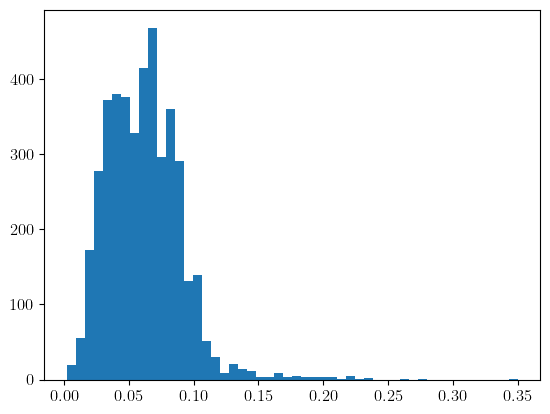

In [33]:
plt.hist(z_all, bins=50)
plt.show()

Normalize the data

In [34]:
from typing import Optional
def normalize_arr(arr: np.ndarray, errors: np.ndarray = None, axis: int = 0, mean: float = None, std: float = None) -> (float, float, float, Optional[np.ndarray]):
    """Normalize numpy array along given axis and its errors if given."""
    if mean is None:
        mean = np.mean(arr, axis=axis, keepdims=True)
    if std is None:
        std = np.std(arr, axis=axis, keepdims=True)
    if not errors is None:
        return (arr - mean) / std, mean[0], std[0], errors / std
    else:
        return (arr - mean) / std, mean, std

In [35]:
# Get the mean and std of the training set
from sed_nn import load_and_preprocess
_, _, _, _, _, _, _, _, _, photo_mean, photo_std, photo_err_norm = load_and_preprocess()

# Call the yse and bts data
X_all_norm, X_mean, X_std = normalize_arr(X_all, mean=photo_mean[:5], std=photo_std[:5])
X_all_norm_err = X_all_err / photo_std[:5]

2024-09-13 22:25:41,097 - sed_nn.py - INFO - Importing photometry data
2024-09-13 22:25:45,057 - sed_nn.py - INFO - Fixing the error for 96514 objects
2024-09-13 22:25:45,075 - sed_nn.py - INFO - Importing photometry data
2024-09-13 22:25:47,221 - sed_nn.py - INFO - Photo stats:
 	mean = [-2.88750664 -2.80485236 -2.79177703 -2.64890962 -2.69422682 -1.33202668
  0.06717019  0.67723176  1.35547094  0.92884049  1.34127727  1.21686633
  1.33390055 -2.42786271 -2.2128036  -1.99193711 -3.04366902 -3.0434582 ]
 	std = [0.6256189  0.69351311 0.67564669 0.71696901 0.78423232 0.88506622
 1.62868632 2.06807325 0.43284611 1.35729201 0.49397298 0.43336611
 0.45556757 2.21415807 2.12945886 2.02186998 0.66726908 0.69343955]
2024-09-13 22:25:47,225 - sed_nn.py - INFO - Catalog stats:
 	mean = [[ 8.69840122 -0.65829206  0.56184221]]
 	std = [[1.31209275 1.35189867 0.29137484]]
2024-09-13 22:25:47,228 - sed_nn.py - INFO - Length = 1261630


HEEERRRREE [[ 0.70927392  1.25512957  0.2270539 ]
 [-0.33256743  0.67634887  0.87570289]
 [-0.2748967   0.76784266  0.57368643]
 ...
 [ 0.60130756 -0.66104664  0.7521507 ]
 [-1.06907597 -0.30847975 -0.19851475]
 [-0.32610561 -0.29959755 -0.82657171]]
[[ 8.69840122 -0.65829206  0.56184221]]


2024-09-13 22:25:48,374 - sed_nn.py - INFO - Splitting into:
	X = ['G', 'R', 'I', 'Z', 'Y']
	y = ['J', 'H', 'Ks', 'CH1', 'CH2', 'MIPS24', 'MIPS70', 'PACS100', 'MIPS160', 'PACS160', 'SPIRE250', 'SPIRE350', 'SPIRE500']


In [36]:
# within_good_range = np.all((X_all_norm < 4) & (X_all_norm > -4), axis=1)
within_good_range = np.array([True for _ in range(len(z_all))])
X_all_norm, X_all_norm_err, z_all = X_all_norm[within_good_range], X_all_norm_err[within_good_range], z_all[within_good_range]
X_all, X_all_err = X_all[within_good_range], X_all_err[within_good_range]

In [37]:
# Also grab the means and std of the host properties
from host_prop_nn import load_and_preprocess

# Scale the properties by the Zou mean and std for later
test, _, photo_train, photo_test, cat_train, cat_test, _, _, _, _, _, hprop_photo_means, hprop_photo_std, _, _, prop_mean, prop_std, _ = load_and_preprocess()

2024-09-13 22:25:48,630 - host_prop_nn.py - INFO - Importing photometry data
2024-09-13 22:25:49,630 - host_prop_nn.py - INFO - Fixing the error for 96514 objects
2024-09-13 22:25:49,646 - host_prop_nn.py - INFO - Dropping 2594528 / 2691042 photozs!
2024-09-13 22:25:49,712 - host_prop_nn.py - INFO - Importing photometry data
2024-09-13 22:25:49,757 - host_prop_nn.py - INFO - Photo stats:
 	mean = [-2.08274563 -1.85131022 -1.91613353 -1.66802481 -1.64246513]
 	std = [0.62591803 0.58210564 0.62691966 0.58754192 0.59550117]
2024-09-13 22:25:49,758 - host_prop_nn.py - INFO - Catalog stats:
 	mean = [ 9.99878348 -0.13575662 -0.3170729 ]
 	std = [0.83429481 1.04090293 0.26033958]
2024-09-13 22:25:49,760 - host_prop_nn.py - INFO - Length = 84672


HEEERRRREE [[ 0.68735514 -3.73327686 -2.95426938]
 [-1.68488085 -0.31710368 -3.29128709]
 [ 1.28118105 -1.88014654 -1.59697336]
 ...
 [-0.91752005 -0.17525813 -0.08646464]
 [-3.6916955  -2.32110538 -3.94510607]
 [-0.55604096 -1.49926118 -0.48175502]]
[ 9.99878348 -0.13575662 -0.3170729 ]


/var/folders/2f/vnb6fr7n7g32fwlgp_k3l3sc0000gn/T/ipykernel_8532/3772614729.py:2: UserWarning: cmr10 font should ideally be used with mathtext, set axes.formatter.use_mathtext to True
  plt.hist(train_zs[(train_zs < 0.2) & (train_zs > 0.0126)], bins=50, alpha=0.5, color='gray', label='training set', density=True)
/Users/adamboesky/opt/anaconda3/envs/ay98_updated/lib/python3.12/site-packages/numpy/lib/histograms.py:885: RuntimeWarning: invalid value encountered in divide
  return n/db/n.sum(), bin_edges


(array([nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan,
        nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan,
        nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan,
        nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan]),
 array([0.  , 0.02, 0.04, 0.06, 0.08, 0.1 , 0.12, 0.14, 0.16, 0.18, 0.2 ,
        0.22, 0.24, 0.26, 0.28, 0.3 , 0.32, 0.34, 0.36, 0.38, 0.4 , 0.42,
        0.44, 0.46, 0.48, 0.5 , 0.52, 0.54, 0.56, 0.58, 0.6 , 0.62, 0.64,
        0.66, 0.68, 0.7 , 0.72, 0.74, 0.76, 0.78, 0.8 , 0.82, 0.84, 0.86,
        0.88, 0.9 , 0.92, 0.94, 0.96, 0.98, 1.  ]),
 <BarContainer object of 50 artists>)

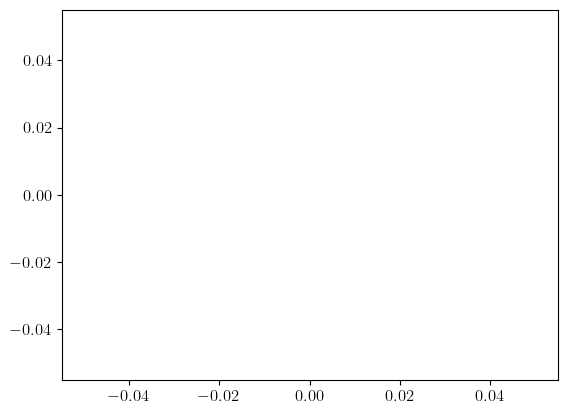

In [38]:
train_zs = cat_train[:, 2] * prop_std[2] + prop_mean[2]
plt.hist(train_zs[(train_zs < 0.2) & (train_zs > 0.0126)], bins=50, alpha=0.5, color='gray', label='training set', density=True)

/var/folders/2f/vnb6fr7n7g32fwlgp_k3l3sc0000gn/T/ipykernel_8532/749871807.py:1: UserWarning: cmr10 font should ideally be used with mathtext, set axes.formatter.use_mathtext to True
  plt.hist(z_all, bins=50, alpha=0.5, label='bts+grizy zs', color='red', density=True)


Text(0.5, 0, 'redshift')

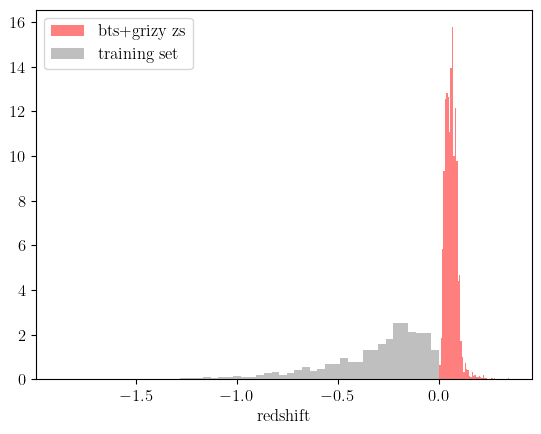

In [39]:
plt.hist(z_all, bins=50, alpha=0.5, label='bts+grizy zs', color='red', density=True)
plt.hist((cat_train * prop_std + prop_mean)[:, 2], bins=50, alpha=0.5, color='gray', label='training set', density=True)
plt.legend()
plt.xlabel('redshift')

/var/folders/2f/vnb6fr7n7g32fwlgp_k3l3sc0000gn/T/ipykernel_10552/111404722.py:1: UserWarning: cmr10 font should ideally be used with mathtext, set axes.formatter.use_mathtext to True
  plt.plot(photo_test[:1000][:, :5].T, color='gray', alpha=0.1)


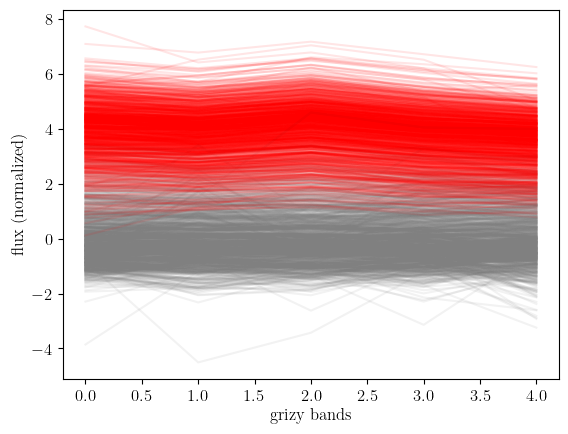

In [40]:
plt.plot(photo_test[:1000][:, :5].T, color='gray', alpha=0.1)
plt.plot(X_all_norm[:1000].T, color='red', alpha=0.1)
plt.xlabel('grizy bands')
plt.ylabel('flux (normalized)')
plt.show()

/var/folders/2f/vnb6fr7n7g32fwlgp_k3l3sc0000gn/T/ipykernel_10552/1429476615.py:1: UserWarning: cmr10 font should ideally be used with mathtext, set axes.formatter.use_mathtext to True
  plt.plot((photo_test * photo_std + photo_mean)[:, :5][-1000:].T, color='gray', alpha=0.1)


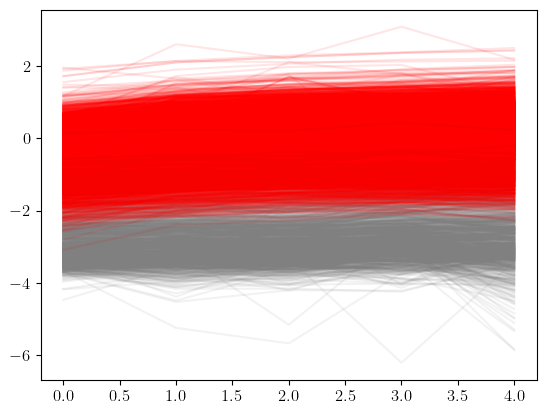

In [15]:
plt.plot((photo_test * photo_std + photo_mean)[:, :5][-1000:].T, color='gray', alpha=0.1)
plt.plot((X_all_norm * photo_std[:5] + photo_mean[:5]).T, color='red', alpha=0.1)
plt.show()

# Domain transfer and infer host properties

## V1

In [16]:
# Training parameters
nodes_per_layer = [7, 9, 11, 13]
num_linear_output_layers = 1
torch.set_default_dtype(torch.float64)
sed_model = get_model(num_inputs=5, num_outputs=13, nodes_per_layer=nodes_per_layer, num_linear_output_layers=num_linear_output_layers)

# Load best model
resume(sed_model, '/Users/adamboesky/Research/ay98/Weird_Galaxies/best_sed_model.pkl')
sed_model.eval()

Sequential(
  (input): Linear(in_features=5, out_features=7, bias=True)
  (act_input): ReLU()
  (layer_0): Linear(in_features=7, out_features=9, bias=True)
  (act_0): ReLU()
  (layer_1): Linear(in_features=9, out_features=11, bias=True)
  (act_1): ReLU()
  (layer_2): Linear(in_features=11, out_features=13, bias=True)
  (act_2): ReLU()
  (output): Linear(in_features=13, out_features=13, bias=True)
)

In [17]:
# Predict the remainder of the SED
sed_preds = sed_model(torch.from_numpy(X_all_norm)).detach().numpy()
X_all_norm_full = np.hstack((X_all_norm, sed_preds))  # note that this is still scaled to be input into the host prop NN

In [18]:
# Load the property-predicting model
n_epochs = 1000
nodes_per_layer = [18, 15, 12, 9, 6, 4]
num_linear_output_layers = 3
learning_rate = 0.01
batch_size = 4096
torch.set_default_dtype(torch.float64)
prop_model = get_model(num_inputs=18, num_outputs=3, nodes_per_layer=nodes_per_layer, num_linear_output_layers=num_linear_output_layers)
loss_fn = CustomLoss()
optimizer = torch.optim.AdamW(prop_model.parameters(), lr=learning_rate)
resume(prop_model, '/Users/adamboesky/Research/ay98/Weird_Galaxies/best_model.pkl')
prop_model.eval()

Sequential(
  (input): Linear(in_features=18, out_features=18, bias=True)
  (act_input): ReLU()
  (layer_0): Linear(in_features=18, out_features=15, bias=True)
  (act_0): ReLU()
  (layer_1): Linear(in_features=15, out_features=12, bias=True)
  (act_1): ReLU()
  (layer_2): Linear(in_features=12, out_features=9, bias=True)
  (act_2): ReLU()
  (layer_3): Linear(in_features=9, out_features=6, bias=True)
  (act_3): ReLU()
  (layer_4): Linear(in_features=6, out_features=4, bias=True)
  (act_4): ReLU()
  (pre_output0): Linear(in_features=4, out_features=4, bias=True)
  (pre_output1): Linear(in_features=4, out_features=4, bias=True)
  (output): Linear(in_features=4, out_features=3, bias=True)
)

/var/folders/2f/vnb6fr7n7g32fwlgp_k3l3sc0000gn/T/ipykernel_10552/1804072685.py:9: UserWarning: cmr10 font should ideally be used with mathtext, set axes.formatter.use_mathtext to True
  fig, ax = plt.subplots(1,1, figsize=(5, 5))
/var/folders/2f/vnb6fr7n7g32fwlgp_k3l3sc0000gn/T/ipykernel_10552/1804072685.py:15: RuntimeWarning: divide by zero encountered in log10
  im = ax.imshow(np.log10(heatmap).T, origin='lower', aspect='auto', cmap='Blues', extent=extent)
/var/folders/2f/vnb6fr7n7g32fwlgp_k3l3sc0000gn/T/ipykernel_10552/1804072685.py:25: UserWarning: cmr10 font should ideally be used with mathtext, set axes.formatter.use_mathtext to True
  cbar = fig.colorbar(im, ax=ax, fraction=0.046, pad=0.04)


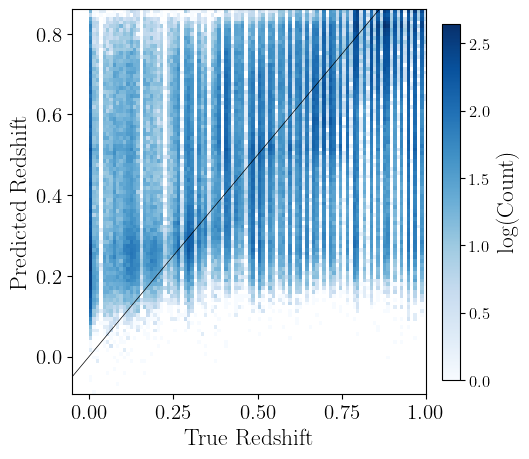

In [19]:
# sed_preds = sed_model(torch.from_numpy(X_all_norm)).detach().numpy()
# X_all_norm_full = np.hstack((X_all_norm, sed_preds))  # note that this is still scaled to be input into the host prop NN

pred_testing = sed_model(torch.from_numpy(photo_test[:, :5])).detach().numpy()
X_testing = np.hstack((photo_test[:, :5], pred_testing))
test_pred = prop_model(torch.from_numpy(X_testing)).detach().numpy()

# Real v pred heatmap
fig, ax = plt.subplots(1,1, figsize=(5, 5))

# Plot
ind = 2
heatmap, xedges, yedges = np.histogram2d(cat_test[:, ind] * prop_std[ind] + prop_mean[ind], test_pred[:, ind] * prop_std[ind] + prop_mean[ind], bins=(100, 100))#, range=[(0,1), (0,1)])
extent = [xedges[0], xedges[-1], yedges[0], yedges[-1]]
im = ax.imshow(np.log10(heatmap).T, origin='lower', aspect='auto', cmap='Blues', extent=extent)
ax.axline((0, 0), slope=1, color='black', linewidth=0.5)
# ax.set_xlim([0,1])
# ax.set_ylim([0,1])
ax.set_xlabel(r'True Redshift', fontsize=17)
ax.set_ylabel(r'Predicted Redshift', fontsize=17)
ax.tick_params(axis='both', which='major', labelsize=15)

# Add a colorbar
# cbar_ax = fig.add_axes([0.92, 0.53, 0.02, 0.1])  # Adjust the position and size as needed
cbar = fig.colorbar(im, ax=ax, fraction=0.046, pad=0.04)
cbar.set_label(r'$\log(\rm{Count})$', fontsize=17)  # Adjust fontsize as needed
# plt.tight_layout()
# plt.savefig('/Users/adamboesky/Research/ay98/Weird_Galaxies/Figures/host_prop_real_v_preds.pdf', bbox_inches='tight')
plt.show()

In [20]:
# Predict the host properties
props_pred = prop_model(torch.from_numpy(X_all_norm_full)).detach().numpy()
props_pred = props_pred * prop_std + prop_mean
z_pred = props_pred[:, 2]

/var/folders/2f/vnb6fr7n7g32fwlgp_k3l3sc0000gn/T/ipykernel_10552/2848507711.py:1: UserWarning: cmr10 font should ideally be used with mathtext, set axes.formatter.use_mathtext to True
  plt.hist(z_pred, bins=50, alpha=0.5, label='pred')


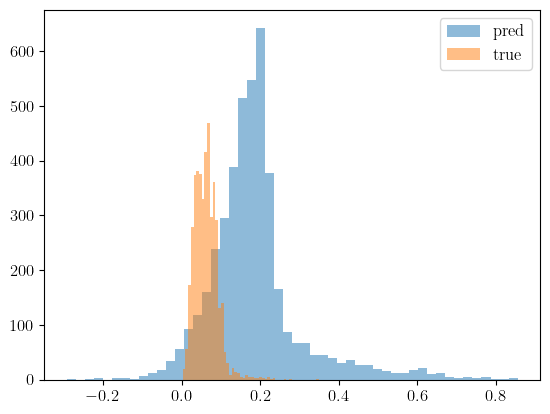

In [21]:
plt.hist(z_pred, bins=50, alpha=0.5, label='pred')
plt.hist(z_all, bins=50, alpha=0.5, label='true')
plt.legend()

/var/folders/2f/vnb6fr7n7g32fwlgp_k3l3sc0000gn/T/ipykernel_10552/3398513432.py:1: UserWarning: cmr10 font should ideally be used with mathtext, set axes.formatter.use_mathtext to True
  plt.scatter(z_all, z_pred, s=5)


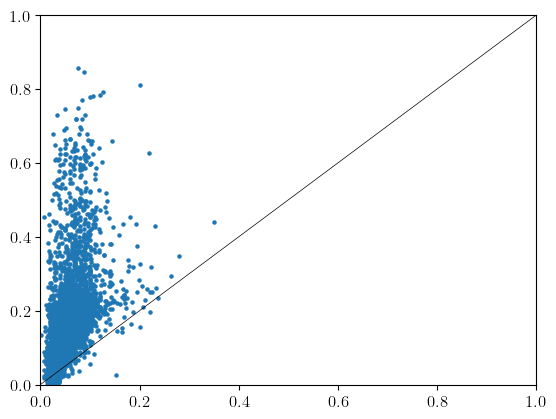

In [22]:
plt.scatter(z_all, z_pred, s=5)
plt.axline((0, 0), slope=1, color='black', linewidth=0.5)
plt.xlim((0, 1))
plt.ylim((0, 1))
plt.show()

/var/folders/2f/vnb6fr7n7g32fwlgp_k3l3sc0000gn/T/ipykernel_10552/899694179.py:2: UserWarning: cmr10 font should ideally be used with mathtext, set axes.formatter.use_mathtext to True
  fig, ax = plt.subplots(1,1, figsize=(5, 5))
/var/folders/2f/vnb6fr7n7g32fwlgp_k3l3sc0000gn/T/ipykernel_10552/899694179.py:7: RuntimeWarning: divide by zero encountered in log10
  im = ax.imshow(np.log10(heatmap).T, origin='lower', aspect='auto', cmap='Blues', extent=extent)
/var/folders/2f/vnb6fr7n7g32fwlgp_k3l3sc0000gn/T/ipykernel_10552/899694179.py:17: UserWarning: cmr10 font should ideally be used with mathtext, set axes.formatter.use_mathtext to True
  cbar = fig.colorbar(im, ax=ax, fraction=0.046, pad=0.04)


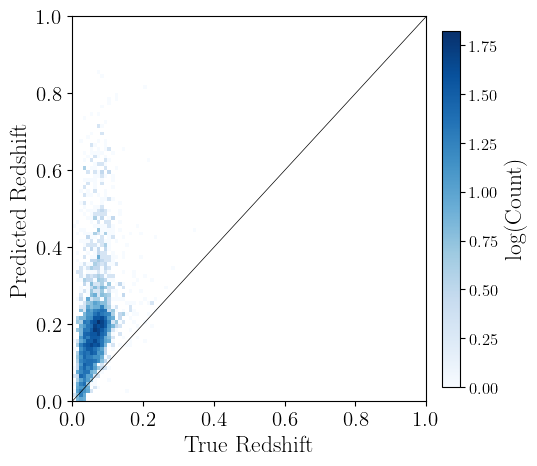

In [23]:
# Real v pred heatmap
fig, ax = plt.subplots(1,1, figsize=(5, 5))

# Plot
heatmap, xedges, yedges = np.histogram2d(z_all, z_pred, bins=(100, 100), range=[(0,1), (0,1)])
extent = [xedges[0], xedges[-1], yedges[0], yedges[-1]]
im = ax.imshow(np.log10(heatmap).T, origin='lower', aspect='auto', cmap='Blues', extent=extent)
ax.axline((0, 0), slope=1, color='black', linewidth=0.5)
ax.set_xlim([0,1])
ax.set_ylim([0,1])
ax.set_xlabel(r'True Redshift', fontsize=17)
ax.set_ylabel(r'Predicted Redshift', fontsize=17)
ax.tick_params(axis='both', which='major', labelsize=15)

# Add a colorbar
# cbar_ax = fig.add_axes([0.92, 0.53, 0.02, 0.1])  # Adjust the position and size as needed
cbar = fig.colorbar(im, ax=ax, fraction=0.046, pad=0.04)
cbar.set_label(r'$\log(\rm{Count})$', fontsize=17)  # Adjust fontsize as needed
# plt.tight_layout()
# plt.savefig('/Users/adamboesky/Research/ay98/Weird_Galaxies/Figures/host_prop_real_v_preds.pdf', bbox_inches='tight')
plt.show()

## V2

In [31]:
# Training parameters
nodes_per_layer = [6, 7, 7, 8]
num_linear_output_layers = 2
torch.set_default_dtype(torch.float64)
sed_model = get_model(num_inputs=5, num_outputs=9, nodes_per_layer=nodes_per_layer, num_linear_output_layers=num_linear_output_layers)

# Load best model
resume(sed_model, '/Users/adamboesky/Research/ay98/Weird_Galaxies/V2_best_sed_model.pkl')
sed_model.eval()

Sequential(
  (input): Linear(in_features=5, out_features=6, bias=True)
  (act_input): ReLU()
  (layer_0): Linear(in_features=6, out_features=7, bias=True)
  (act_0): ReLU()
  (layer_1): Linear(in_features=7, out_features=7, bias=True)
  (act_1): ReLU()
  (layer_2): Linear(in_features=7, out_features=8, bias=True)
  (act_2): ReLU()
  (pre_output0): Linear(in_features=8, out_features=8, bias=True)
  (output): Linear(in_features=8, out_features=9, bias=True)
)

In [32]:
# Predict the remainder of the SED
sed_preds = sed_model(torch.from_numpy(X_all_norm)).detach().numpy()
X_all_norm_full = np.hstack((X_all_norm, sed_preds))  # note that this is still scaled to be input into the host prop NN

In [33]:
# Load the property-predicting model
n_epochs = 1000
nodes_per_layer = [12, 10, 8, 6, 4]
num_linear_output_layers = 3
learning_rate = 0.01
batch_size = 4096
torch.set_default_dtype(torch.float64)
prop_model = get_model(num_inputs=14, num_outputs=3, nodes_per_layer=nodes_per_layer, num_linear_output_layers=num_linear_output_layers)
loss_fn = CustomLoss()
optimizer = torch.optim.AdamW(prop_model.parameters(), lr=learning_rate)
resume(prop_model, '/Users/adamboesky/Research/ay98/Weird_Galaxies/V2_host_prop_best_model.pkl')
prop_model.eval()

Sequential(
  (input): Linear(in_features=14, out_features=12, bias=True)
  (act_input): ReLU()
  (layer_0): Linear(in_features=12, out_features=10, bias=True)
  (act_0): ReLU()
  (layer_1): Linear(in_features=10, out_features=8, bias=True)
  (act_1): ReLU()
  (layer_2): Linear(in_features=8, out_features=6, bias=True)
  (act_2): ReLU()
  (layer_3): Linear(in_features=6, out_features=4, bias=True)
  (act_3): ReLU()
  (pre_output0): Linear(in_features=4, out_features=4, bias=True)
  (pre_output1): Linear(in_features=4, out_features=4, bias=True)
  (output): Linear(in_features=4, out_features=3, bias=True)
)

In [34]:
# Predict the host properties
props_pred = prop_model(torch.from_numpy(X_all_norm_full)).detach().numpy()
props_pred = props_pred * prop_std + prop_mean
z_pred = props_pred[:, 2]

/var/folders/2f/vnb6fr7n7g32fwlgp_k3l3sc0000gn/T/ipykernel_10552/2848507711.py:1: UserWarning: cmr10 font should ideally be used with mathtext, set axes.formatter.use_mathtext to True
  plt.hist(z_pred, bins=50, alpha=0.5, label='pred')


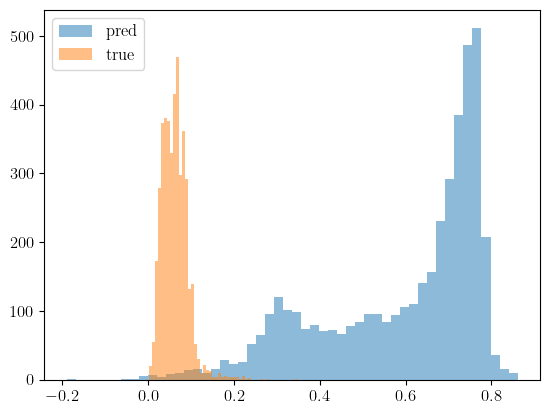

In [35]:
plt.hist(z_pred, bins=50, alpha=0.5, label='pred')
plt.hist(z_all, bins=50, alpha=0.5, label='true')
plt.legend()

/var/folders/2f/vnb6fr7n7g32fwlgp_k3l3sc0000gn/T/ipykernel_10552/3398513432.py:1: UserWarning: cmr10 font should ideally be used with mathtext, set axes.formatter.use_mathtext to True
  plt.scatter(z_all, z_pred, s=5)


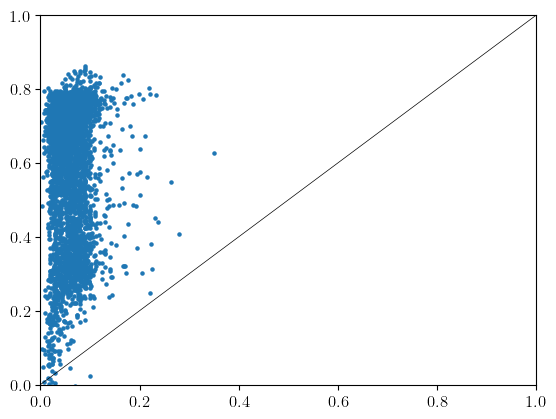

In [36]:
plt.scatter(z_all, z_pred, s=5)
plt.axline((0, 0), slope=1, color='black', linewidth=0.5)
plt.xlim((0, 1))
plt.ylim((0, 1))
plt.show()

/var/folders/2f/vnb6fr7n7g32fwlgp_k3l3sc0000gn/T/ipykernel_10552/899694179.py:2: UserWarning: cmr10 font should ideally be used with mathtext, set axes.formatter.use_mathtext to True
  fig, ax = plt.subplots(1,1, figsize=(5, 5))
/var/folders/2f/vnb6fr7n7g32fwlgp_k3l3sc0000gn/T/ipykernel_10552/899694179.py:7: RuntimeWarning: divide by zero encountered in log10
  im = ax.imshow(np.log10(heatmap).T, origin='lower', aspect='auto', cmap='Blues', extent=extent)
/var/folders/2f/vnb6fr7n7g32fwlgp_k3l3sc0000gn/T/ipykernel_10552/899694179.py:17: UserWarning: cmr10 font should ideally be used with mathtext, set axes.formatter.use_mathtext to True
  cbar = fig.colorbar(im, ax=ax, fraction=0.046, pad=0.04)


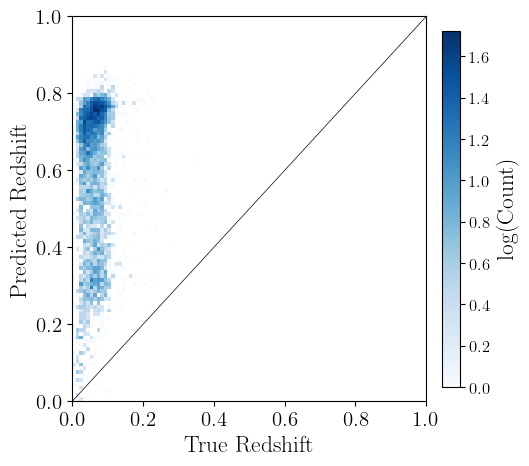

In [30]:
# Real v pred heatmap
fig, ax = plt.subplots(1,1, figsize=(5, 5))

# Plot
heatmap, xedges, yedges = np.histogram2d(z_all, z_pred, bins=(100, 100), range=[(0,1), (0,1)])
extent = [xedges[0], xedges[-1], yedges[0], yedges[-1]]
im = ax.imshow(np.log10(heatmap).T, origin='lower', aspect='auto', cmap='Blues', extent=extent)
ax.axline((0, 0), slope=1, color='black', linewidth=0.5)
ax.set_xlim([0,1])
ax.set_ylim([0,1])
ax.set_xlabel(r'True Redshift', fontsize=17)
ax.set_ylabel(r'Predicted Redshift', fontsize=17)
ax.tick_params(axis='both', which='major', labelsize=15)

# Add a colorbar
# cbar_ax = fig.add_axes([0.92, 0.53, 0.02, 0.1])  # Adjust the position and size as needed
cbar = fig.colorbar(im, ax=ax, fraction=0.046, pad=0.04)
cbar.set_label(r'$\log(\rm{Count})$', fontsize=17)  # Adjust fontsize as needed
# plt.tight_layout()
# plt.savefig('/Users/adamboesky/Research/ay98/Weird_Galaxies/Figures/host_prop_real_v_preds.pdf', bbox_inches='tight')
plt.show()

# Try using my nice pipeline class

In [13]:
import importlib
import SPLASH.pipeline as pipeline  # Make sure this imports the module where SnPipeline is defined

# Reload the module
importlib.reload(pipeline)

# Now you can use the updated SnPipeline class
from SPLASH.pipeline import SnPipeline

In [14]:
pipeline = SnPipeline(pipeline_version='V2_full_band_powlaw6_weighted')
pipe_preds = pipeline.predict_host_properties(X_all_norm)

ValueError: V2_full_band_powlaw6_weighted is not an option for your pipeline version, it must either be 'full_band' or 'best_band' or 'weighted_full_band'

/var/folders/2f/vnb6fr7n7g32fwlgp_k3l3sc0000gn/T/ipykernel_12791/3014746173.py:2: UserWarning: cmr10 font should ideally be used with mathtext, set axes.formatter.use_mathtext to True
  fig, ax = plt.subplots(1,1, figsize=(5, 5))
/var/folders/2f/vnb6fr7n7g32fwlgp_k3l3sc0000gn/T/ipykernel_12791/3014746173.py:7: RuntimeWarning: divide by zero encountered in log10
  im = ax.imshow(np.log10(heatmap).T, origin='lower', aspect='auto', cmap='Blues', extent=extent)
/var/folders/2f/vnb6fr7n7g32fwlgp_k3l3sc0000gn/T/ipykernel_12791/3014746173.py:17: UserWarning: cmr10 font should ideally be used with mathtext, set axes.formatter.use_mathtext to True
  cbar = fig.colorbar(im, ax=ax, fraction=0.046, pad=0.04)


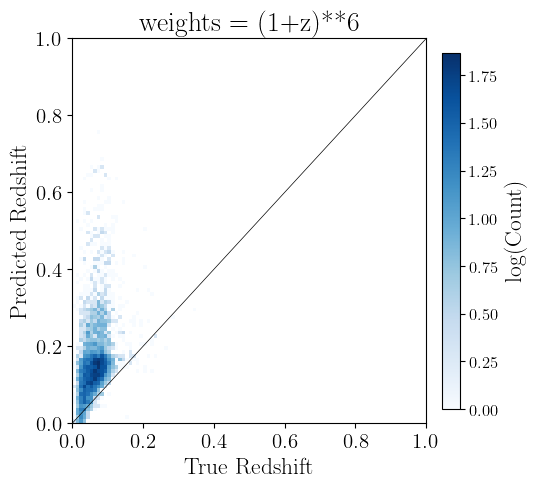

In [19]:
# Real v pred heatmap
fig, ax = plt.subplots(1,1, figsize=(5, 5))

# Plot
heatmap, xedges, yedges = np.histogram2d(z_all, (pipe_preds * prop_std + prop_mean)[:, 2], bins=(100, 100), range=[(0,1), (0,1)])
extent = [xedges[0], xedges[-1], yedges[0], yedges[-1]]
im = ax.imshow(np.log10(heatmap).T, origin='lower', aspect='auto', cmap='Blues', extent=extent)
ax.axline((0, 0), slope=1, color='black', linewidth=0.5)
ax.set_xlim([0,1])
ax.set_ylim([0,1])
ax.set_xlabel(r'True Redshift', fontsize=17)
ax.set_ylabel(r'Predicted Redshift', fontsize=17)
ax.tick_params(axis='both', which='major', labelsize=15)

# Add a colorbar
# cbar_ax = fig.add_axes([0.92, 0.53, 0.02, 0.1])  # Adjust the position and size as needed
cbar = fig.colorbar(im, ax=ax, fraction=0.046, pad=0.04)
cbar.set_label(r'$\log(\rm{Count})$', fontsize=17)  # Adjust fontsize as needed
plt.title('weights = (1+z)**6', fontsize=20)
plt.show()

In [20]:
pipeline = SnPipeline(pipeline_version='full_band_powlaw6_weighted')
pipe_preds = pipeline.predict_host_properties(X_all_norm)

/var/folders/2f/vnb6fr7n7g32fwlgp_k3l3sc0000gn/T/ipykernel_12791/1759452353.py:2: UserWarning: cmr10 font should ideally be used with mathtext, set axes.formatter.use_mathtext to True
  fig, ax = plt.subplots(1,1, figsize=(5, 5))
/var/folders/2f/vnb6fr7n7g32fwlgp_k3l3sc0000gn/T/ipykernel_12791/1759452353.py:7: RuntimeWarning: divide by zero encountered in log10
  im = ax.imshow(np.log10(heatmap).T, origin='lower', aspect='auto', cmap='Blues', extent=extent)
/var/folders/2f/vnb6fr7n7g32fwlgp_k3l3sc0000gn/T/ipykernel_12791/1759452353.py:17: UserWarning: cmr10 font should ideally be used with mathtext, set axes.formatter.use_mathtext to True
  cbar = fig.colorbar(im, ax=ax, fraction=0.046, pad=0.04)


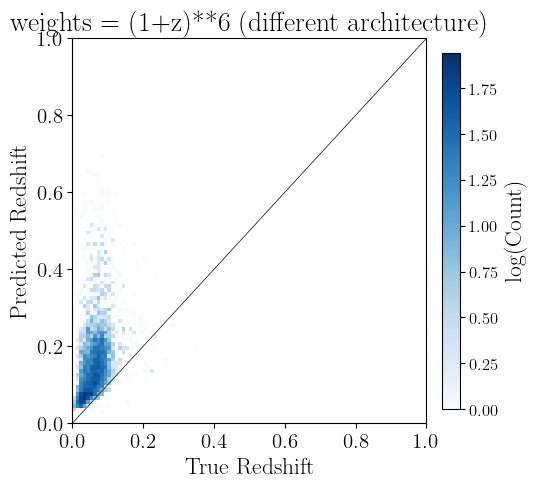

In [21]:
# Real v pred heatmap
fig, ax = plt.subplots(1,1, figsize=(5, 5))

# Plot
heatmap, xedges, yedges = np.histogram2d(z_all, (pipe_preds * prop_std + prop_mean)[:, 2], bins=(100, 100), range=[(0,1), (0,1)])
extent = [xedges[0], xedges[-1], yedges[0], yedges[-1]]
im = ax.imshow(np.log10(heatmap).T, origin='lower', aspect='auto', cmap='Blues', extent=extent)
ax.axline((0, 0), slope=1, color='black', linewidth=0.5)
ax.set_xlim([0,1])
ax.set_ylim([0,1])
ax.set_xlabel(r'True Redshift', fontsize=17)
ax.set_ylabel(r'Predicted Redshift', fontsize=17)
ax.tick_params(axis='both', which='major', labelsize=15)

# Add a colorbar
# cbar_ax = fig.add_axes([0.92, 0.53, 0.02, 0.1])  # Adjust the position and size as needed
cbar = fig.colorbar(im, ax=ax, fraction=0.046, pad=0.04)
cbar.set_label(r'$\log(\rm{Count})$', fontsize=17)  # Adjust fontsize as needed
plt.title('weights = (1+z)**6 (different architecture)', fontsize=20)
plt.show()

In [22]:
pipeline = SnPipeline(pipeline_version='full_band_powlaw4_weighted')
pipe_preds = pipeline.predict_host_properties(X_all_norm)

/var/folders/2f/vnb6fr7n7g32fwlgp_k3l3sc0000gn/T/ipykernel_12791/1794658433.py:2: UserWarning: cmr10 font should ideally be used with mathtext, set axes.formatter.use_mathtext to True
  fig, ax = plt.subplots(1,1, figsize=(5, 5))
/var/folders/2f/vnb6fr7n7g32fwlgp_k3l3sc0000gn/T/ipykernel_12791/1794658433.py:7: RuntimeWarning: divide by zero encountered in log10
  im = ax.imshow(np.log10(heatmap).T, origin='lower', aspect='auto', cmap='Blues', extent=extent)
/var/folders/2f/vnb6fr7n7g32fwlgp_k3l3sc0000gn/T/ipykernel_12791/1794658433.py:17: UserWarning: cmr10 font should ideally be used with mathtext, set axes.formatter.use_mathtext to True
  cbar = fig.colorbar(im, ax=ax, fraction=0.046, pad=0.04)


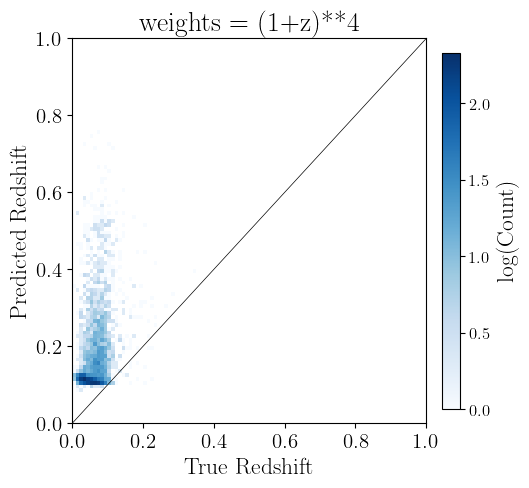

In [23]:
# Real v pred heatmap
fig, ax = plt.subplots(1,1, figsize=(5, 5))

# Plot
heatmap, xedges, yedges = np.histogram2d(z_all, (pipe_preds * prop_std + prop_mean)[:, 2], bins=(100, 100), range=[(0,1), (0,1)])
extent = [xedges[0], xedges[-1], yedges[0], yedges[-1]]
im = ax.imshow(np.log10(heatmap).T, origin='lower', aspect='auto', cmap='Blues', extent=extent)
ax.axline((0, 0), slope=1, color='black', linewidth=0.5)
ax.set_xlim([0,1])
ax.set_ylim([0,1])
ax.set_xlabel(r'True Redshift', fontsize=17)
ax.set_ylabel(r'Predicted Redshift', fontsize=17)
ax.tick_params(axis='both', which='major', labelsize=15)

# Add a colorbar
# cbar_ax = fig.add_axes([0.92, 0.53, 0.02, 0.1])  # Adjust the position and size as needed
cbar = fig.colorbar(im, ax=ax, fraction=0.046, pad=0.04)
cbar.set_label(r'$\log(\rm{Count})$', fontsize=17)  # Adjust fontsize as needed
plt.title('weights = (1+z)**4', fontsize=20)
plt.show()

In [24]:
pipeline = SnPipeline()
pipe_preds = pipeline.predict_host_properties(X_all_norm)

/var/folders/2f/vnb6fr7n7g32fwlgp_k3l3sc0000gn/T/ipykernel_12791/3345749997.py:2: UserWarning: cmr10 font should ideally be used with mathtext, set axes.formatter.use_mathtext to True
  fig, ax = plt.subplots(1,1, figsize=(5, 5))
/var/folders/2f/vnb6fr7n7g32fwlgp_k3l3sc0000gn/T/ipykernel_12791/3345749997.py:7: RuntimeWarning: divide by zero encountered in log10
  im = ax.imshow(np.log10(heatmap).T, origin='lower', aspect='auto', cmap='Blues', extent=extent)
/var/folders/2f/vnb6fr7n7g32fwlgp_k3l3sc0000gn/T/ipykernel_12791/3345749997.py:17: UserWarning: cmr10 font should ideally be used with mathtext, set axes.formatter.use_mathtext to True
  cbar = fig.colorbar(im, ax=ax, fraction=0.046, pad=0.04)


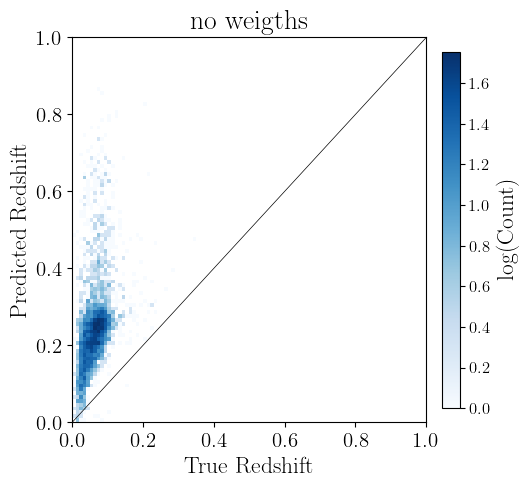

In [25]:
# Real v pred heatmap
fig, ax = plt.subplots(1,1, figsize=(5, 5))

# Plot
heatmap, xedges, yedges = np.histogram2d(z_all, (pipe_preds * prop_std + prop_mean)[:, 2], bins=(100, 100), range=[(0,1), (0,1)])
extent = [xedges[0], xedges[-1], yedges[0], yedges[-1]]
im = ax.imshow(np.log10(heatmap).T, origin='lower', aspect='auto', cmap='Blues', extent=extent)
ax.axline((0, 0), slope=1, color='black', linewidth=0.5)
ax.set_xlim([0,1])
ax.set_ylim([0,1])
ax.set_xlabel(r'True Redshift', fontsize=17)
ax.set_ylabel(r'Predicted Redshift', fontsize=17)
ax.tick_params(axis='both', which='major', labelsize=15)

# Add a colorbar
# cbar_ax = fig.add_axes([0.92, 0.53, 0.02, 0.1])  # Adjust the position and size as needed
cbar = fig.colorbar(im, ax=ax, fraction=0.046, pad=0.04)
cbar.set_label(r'$\log(\rm{Count})$', fontsize=17)  # Adjust fontsize as needed
plt.title('no weigths', fontsize=20)
plt.show()

In [26]:
pipeline = SnPipeline(pipeline_version='full_band_weighted')
pipe_preds = pipeline.predict_host_properties(X_all_norm)

/var/folders/2f/vnb6fr7n7g32fwlgp_k3l3sc0000gn/T/ipykernel_12791/595830393.py:2: UserWarning: cmr10 font should ideally be used with mathtext, set axes.formatter.use_mathtext to True
  fig, ax = plt.subplots(1,1, figsize=(5, 5))
/var/folders/2f/vnb6fr7n7g32fwlgp_k3l3sc0000gn/T/ipykernel_12791/595830393.py:7: RuntimeWarning: divide by zero encountered in log10
  im = ax.imshow(np.log10(heatmap).T, origin='lower', aspect='auto', cmap='Blues', extent=extent)
/var/folders/2f/vnb6fr7n7g32fwlgp_k3l3sc0000gn/T/ipykernel_12791/595830393.py:17: UserWarning: cmr10 font should ideally be used with mathtext, set axes.formatter.use_mathtext to True
  cbar = fig.colorbar(im, ax=ax, fraction=0.046, pad=0.04)


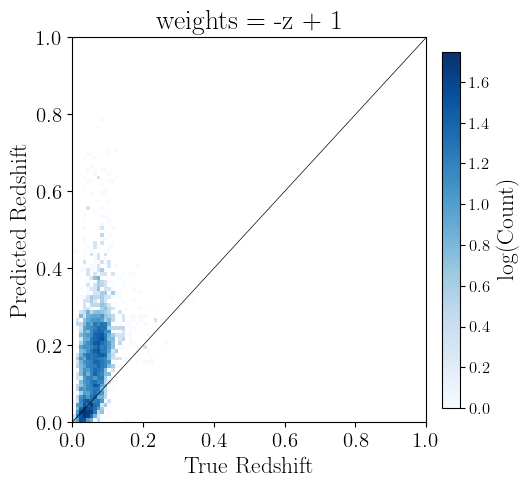

In [27]:
# Real v pred heatmap
fig, ax = plt.subplots(1,1, figsize=(5, 5))

# Plot
heatmap, xedges, yedges = np.histogram2d(z_all, (pipe_preds * prop_std + prop_mean)[:, 2], bins=(100, 100), range=[(0,1), (0,1)])
extent = [xedges[0], xedges[-1], yedges[0], yedges[-1]]
im = ax.imshow(np.log10(heatmap).T, origin='lower', aspect='auto', cmap='Blues', extent=extent)
ax.axline((0, 0), slope=1, color='black', linewidth=0.5)
ax.set_xlim([0,1])
ax.set_ylim([0,1])
ax.set_xlabel(r'True Redshift', fontsize=17)
ax.set_ylabel(r'Predicted Redshift', fontsize=17)
ax.tick_params(axis='both', which='major', labelsize=15)

# Add a colorbar
# cbar_ax = fig.add_axes([0.92, 0.53, 0.02, 0.1])  # Adjust the position and size as needed
cbar = fig.colorbar(im, ax=ax, fraction=0.046, pad=0.04)
cbar.set_label(r'$\log(\rm{Count})$', fontsize=17)  # Adjust fontsize as needed
plt.title('weights = -z + 1', fontsize=20)
plt.show()

In [32]:
pipeline = SnPipeline(pipeline_version='tuned_weighted')
pipe_preds = pipeline.predict_host_properties(X_all_norm)

/var/folders/2f/vnb6fr7n7g32fwlgp_k3l3sc0000gn/T/ipykernel_12791/2528072005.py:2: UserWarning: cmr10 font should ideally be used with mathtext, set axes.formatter.use_mathtext to True
  fig, ax = plt.subplots(1,1, figsize=(5, 5))
/var/folders/2f/vnb6fr7n7g32fwlgp_k3l3sc0000gn/T/ipykernel_12791/2528072005.py:7: RuntimeWarning: divide by zero encountered in log10
  im = ax.imshow(np.log10(heatmap).T, origin='lower', aspect='auto', cmap='Blues', extent=extent)
/var/folders/2f/vnb6fr7n7g32fwlgp_k3l3sc0000gn/T/ipykernel_12791/2528072005.py:17: UserWarning: cmr10 font should ideally be used with mathtext, set axes.formatter.use_mathtext to True
  cbar = fig.colorbar(im, ax=ax, fraction=0.046, pad=0.04)


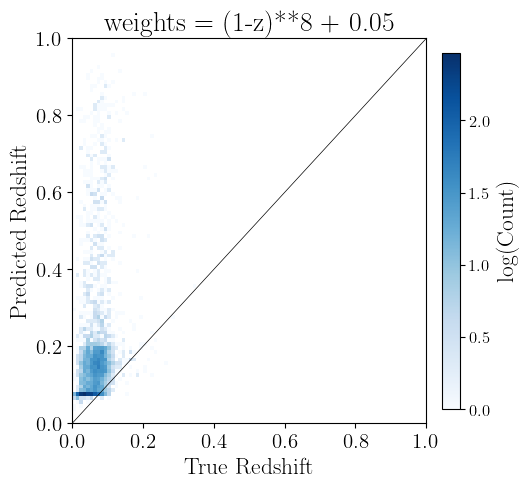

In [34]:
# Real v pred heatmap
fig, ax = plt.subplots(1,1, figsize=(5, 5))

# Plot
heatmap, xedges, yedges = np.histogram2d(z_all, (pipe_preds * prop_std + prop_mean)[:, 2], bins=(100, 100), range=[(0,1), (0,1)])
extent = [xedges[0], xedges[-1], yedges[0], yedges[-1]]
im = ax.imshow(np.log10(heatmap).T, origin='lower', aspect='auto', cmap='Blues', extent=extent)
ax.axline((0, 0), slope=1, color='black', linewidth=0.5)
ax.set_xlim([0,1])
ax.set_ylim([0,1])
ax.set_xlabel(r'True Redshift', fontsize=17)
ax.set_ylabel(r'Predicted Redshift', fontsize=17)
ax.tick_params(axis='both', which='major', labelsize=15)

# Add a colorbar
# cbar_ax = fig.add_axes([0.92, 0.53, 0.02, 0.1])  # Adjust the position and size as needed
cbar = fig.colorbar(im, ax=ax, fraction=0.046, pad=0.04)
cbar.set_label(r'$\log(\rm{Count})$', fontsize=17)  # Adjust fontsize as needed
plt.title('weights = (1-z)**8 + 0.05', fontsize=20)
plt.show()

In [20]:
pipeline = SnPipeline(pipeline_version='weighted_full_band')
pipe_preds = pipeline.predict_host_properties(X_all_norm, X_grizy_err=X_all_norm_err)

/var/folders/2f/vnb6fr7n7g32fwlgp_k3l3sc0000gn/T/ipykernel_60906/2706018367.py:2: UserWarning: cmr10 font should ideally be used with mathtext, set axes.formatter.use_mathtext to True
  fig, ax = plt.subplots(1,1, figsize=(6, 5))
/var/folders/2f/vnb6fr7n7g32fwlgp_k3l3sc0000gn/T/ipykernel_60906/2706018367.py:7: RuntimeWarning: divide by zero encountered in log10
  im = ax.imshow(np.log10(heatmap).T, origin='lower', aspect='auto', cmap='Reds', extent=extent)
/var/folders/2f/vnb6fr7n7g32fwlgp_k3l3sc0000gn/T/ipykernel_60906/2706018367.py:17: UserWarning: cmr10 font should ideally be used with mathtext, set axes.formatter.use_mathtext to True
  cbar = fig.colorbar(im, ax=ax, fraction=0.046, pad=0.04)


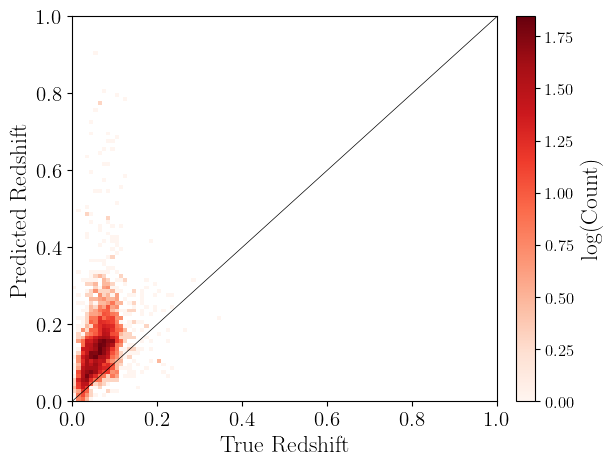

In [23]:
# Real v pred heatmap
fig, ax = plt.subplots(1,1, figsize=(6, 5))

# Plot
heatmap, xedges, yedges = np.histogram2d(z_all, (pipe_preds * prop_std + prop_mean)[:, 2], bins=(100, 100), range=[(0,1), (0,1)])
extent = [xedges[0], xedges[-1], yedges[0], yedges[-1]]
im = ax.imshow(np.log10(heatmap).T, origin='lower', aspect='auto', cmap='Reds', extent=extent)
ax.axline((0, 0), slope=1, color='black', linewidth=0.5)
ax.set_xlim([0,1])
ax.set_ylim([0,1])
ax.set_xlabel(r'True Redshift', fontsize=17)
ax.set_ylabel(r'Predicted Redshift', fontsize=17)
ax.tick_params(axis='both', which='major', labelsize=15)

# Add a colorbar
# cbar_ax = fig.add_axes([0.92, 0.53, 0.02, 0.1])  # Adjust the position and size as needed
cbar = fig.colorbar(im, ax=ax, fraction=0.046, pad=0.04)
cbar.set_label(r'$\log(\rm{Count})$', fontsize=17)  # Adjust fontsize as needed
plt.savefig('Figures/yse_bts_redshift.pdf', bbox_inches='tight')
plt.show()

# Final Plot

In [70]:
import SPLASH
import importlib
importlib.reload(SPLASH.pipeline)   
from SPLASH.pipeline import Splash_Pipeline

In [71]:
pipeline = Splash_Pipeline(pipeline_version='full_band_no_photozs_zloss_grizy_weighted', pre_transformed=True, within_4sigma=False)
pipe_preds = pipeline.predict_host_properties(X_all_norm, X_grizy_err=X_all_norm_err, return_normalized=False, n_resamples=50)[0]

/var/folders/2f/vnb6fr7n7g32fwlgp_k3l3sc0000gn/T/ipykernel_41129/601192519.py:2: UserWarning: cmr10 font should ideally be used with mathtext, set axes.formatter.use_mathtext to True
  fig, ax = plt.subplots(1,1, figsize=(6, 5))
/var/folders/2f/vnb6fr7n7g32fwlgp_k3l3sc0000gn/T/ipykernel_41129/601192519.py:7: RuntimeWarning: divide by zero encountered in log10
  im = ax.imshow(np.log10(heatmap).T, origin='lower', aspect='auto', cmap='Reds', extent=extent)
/var/folders/2f/vnb6fr7n7g32fwlgp_k3l3sc0000gn/T/ipykernel_41129/601192519.py:16: UserWarning: cmr10 font should ideally be used with mathtext, set axes.formatter.use_mathtext to True
  cbar = fig.colorbar(im, ax=ax, fraction=0.046, pad=0.04)


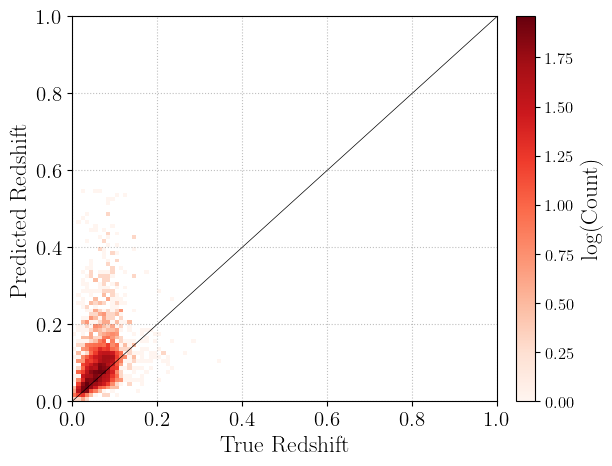

In [15]:
# Real v pred heatmap
fig, ax = plt.subplots(1,1, figsize=(6, 5))

# Plot
heatmap, xedges, yedges = np.histogram2d(z_all, pipe_preds[:, 2], bins=(100, 100), range=[(0,1), (0,1)])
extent = [xedges[0], xedges[-1], yedges[0], yedges[-1]]
im = ax.imshow(np.log10(heatmap).T, origin='lower', aspect='auto', cmap='Reds', extent=extent)
ax.axline((0, 0), slope=1, color='black', linewidth=0.5)
ax.set_xlim([0,1])
ax.set_ylim([0,1])
ax.set_xlabel(r'True Redshift', fontsize=17)
ax.set_ylabel(r'Predicted Redshift', fontsize=17)
ax.tick_params(axis='both', which='major', labelsize=15)

# Add a colorbar
cbar = fig.colorbar(im, ax=ax, fraction=0.046, pad=0.04)
cbar.set_label(r'$\log(\rm{Count})$', fontsize=17)  # Adjust fontsize as needed
ax.grid(color='gray', linestyle=':', alpha=0.5)
# plt.savefig('Figures/yse_bts_redshift.pdf', bbox_inches='tight')
plt.show()

/var/folders/2f/vnb6fr7n7g32fwlgp_k3l3sc0000gn/T/ipykernel_8532/1626191482.py:2: UserWarning: cmr10 font should ideally be used with mathtext, set axes.formatter.use_mathtext to True
  fig, ax = plt.subplots(1,1, figsize=(6, 5))
/var/folders/2f/vnb6fr7n7g32fwlgp_k3l3sc0000gn/T/ipykernel_8532/1626191482.py:7: RuntimeWarning: divide by zero encountered in log10
  im = ax.imshow(np.log10(heatmap).T, origin='lower', aspect='auto', cmap='Reds', extent=extent)
/var/folders/2f/vnb6fr7n7g32fwlgp_k3l3sc0000gn/T/ipykernel_8532/1626191482.py:16: UserWarning: cmr10 font should ideally be used with mathtext, set axes.formatter.use_mathtext to True
  cbar = fig.colorbar(im, ax=ax, fraction=0.046, pad=0.04)


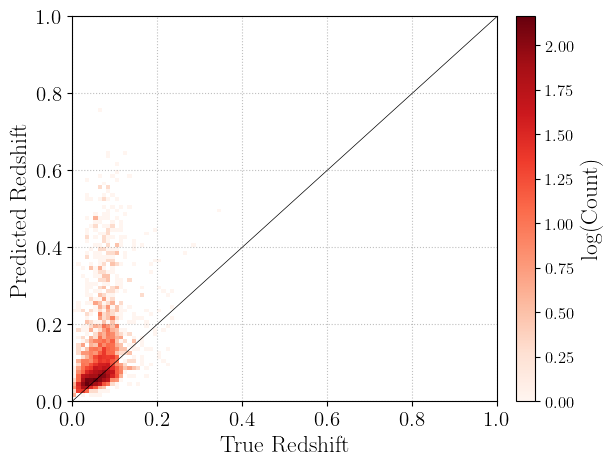

In [80]:
# Real v pred heatmap
fig, ax = plt.subplots(1,1, figsize=(6, 5))

# Plot
heatmap, xedges, yedges = np.histogram2d(z_all, pipe_preds[:, 2], bins=(100, 100), range=[(0,1), (0,1)])
extent = [xedges[0], xedges[-1], yedges[0], yedges[-1]]
im = ax.imshow(np.log10(heatmap).T, origin='lower', aspect='auto', cmap='Reds', extent=extent)
ax.axline((0, 0), slope=1, color='black', linewidth=0.5)
ax.set_xlim([0,1])
ax.set_ylim([0,1])
ax.set_xlabel(r'True Redshift', fontsize=17)
ax.set_ylabel(r'Predicted Redshift', fontsize=17)
ax.tick_params(axis='both', which='major', labelsize=15)

# Add a colorbar
cbar = fig.colorbar(im, ax=ax, fraction=0.046, pad=0.04)
cbar.set_label(r'$\log(\rm{Count})$', fontsize=17)  # Adjust fontsize as needed
ax.grid(color='gray', linestyle=':', alpha=0.5)
plt.savefig('Figures/yse_bts_redshift.pdf', bbox_inches='tight')
plt.show()

In [73]:
classification_groups = [['ia'], ['ib', 'ic'], ['slsn'], ['iin'], ['ii', 'iip', 'ii p', 'iil', 'ii l']]
lowercase_groups = {cls.lower(): i for i, group in enumerate(classification_groups) for cls in group}

# Function to get the category id for a supernova class
def get_category_id(sn_class_list):
    for sn_class in sn_class_list:
        sn_class_lower = sn_class.lower()
        for group, group_id in lowercase_groups.items():
            if group in sn_class_lower:
                return group_id
    return np.max(list(lowercase_groups.values())) + 1  # Return a default id if no category is found

# Add 'category_id' column to the DataFrame
classes_reg = pd.Series(true_classes).apply(lambda x: get_category_id(x.split(','))).to_numpy()

In [74]:
# splash_props = (pipe_preds * prop_std + prop_mean)
splash_props = pipe_preds
splash_classes = pipeline.predict_classes(X_all_norm, angular_sep=angular_seps, X_grizy_err=X_all_norm_err, n_resamples=50)
label_dict = {0: 'Ia', 1: 'Ib/c', 2: 'SLSN', 3: 'IIn', 4: 'II (P/L)'}
splash_class_labs = np.array([label_dict[sc] for sc in splash_classes])
true_class_labs = np.array([label_dict[sc] for sc in classes_reg])

In [75]:
df_for_villar = pd.DataFrame(columns=[f'log10({c}) [mJy]' for c in 'grizy'], data=X_all)
prop_df = pd.DataFrame(columns=['log10(M_*) [M_sol]', 'log10(SFR) [M_sol/yr]', 'redshift'], data=splash_props)
df_for_villar = pd.concat((df_for_villar, prop_df), axis=1)
df_for_villar['SPLASH Class'] = splash_class_labs
df_for_villar['Given Class'] = true_class_labs
df_for_villar['SN_ra'], df_for_villar['SN_dec'] = all_sn_ra, all_sn_dec
df_for_villar

,log10(g) [mJy],log10(r) [mJy],log10(i) [mJy],log10(z) [mJy],log10(y) [mJy],log10(M_*) [M_sol],log10(SFR) [M_sol/yr],redshift,SPLASH Class,Given Class,SN_ra,SN_dec
0,-0.73548,-0.62984,-0.59000,-0.58128,-0.55284,9.915339,-0.895028,0.072364,Ia,II (P/L),146.514792,33.528250
1,-0.93912,-1.06340,-0.89864,-0.97204,-0.88884,10.172395,-0.413058,0.141540,Ia,II (P/L),134.954667,38.109056
2,-0.05300,0.29912,0.45796,0.55744,0.65672,10.929260,-0.635801,0.056903,Ia,Ia,120.648958,50.922528
3,-0.34776,-0.22788,-0.18688,-0.16928,-0.14544,10.113092,-0.941724,0.058229,Ia,II (P/L),129.533958,31.667917
4,-0.52508,-0.18456,0.03908,0.15504,0.23008,11.160145,0.005673,0.149951,Ia,Ia,98.507708,43.409028
...,...,...,...,...,...,...,...,...,...,...,...,...
4269,-0.66260,-0.36228,-0.19968,-0.09904,-0.02180,11.029624,-0.124580,0.130474,Ia,Ia,22.065450,-14.051486
4270,0.67844,0.99236,1.15488,1.25376,1.34448,10.940045,-0.928177,0.033790,Ia,Ia,322.906997,11.832946
4271,-0.21720,-0.02644,0.15552,0.18996,0.26072,10.848473,-0.553428,0.069566,Ia,Ib/c,317.348935,9.760885
4272,-0.02856,0.14332,0.23176,0.29468,0.34220,10.635999,-0.761557,0.055818,Ia,Ia,140.211901,42.272211


In [76]:
other_bands = ['J', 'H','Ks', 'CH1', 'CH2', 'MIPS24', 'MIPS70', 'PACS100', 'MIPS160', 'PACS160', 'SPIRE250', 'SPIRE350', 'SPIRE500']
seds_preds, sederrs_preds = pipeline.infer_sed(X_all_norm, X_grizy_err=X_all_norm_err, return_normalized=False, n_resamples=50)
for b, pred, prederr in zip(other_bands, seds_preds[:, 5:].T, sederrs_preds[:, 5:].T):
    df_for_villar[f'{b}_pred [nm]'] = pred
    df_for_villar[f'{b}_prederr [nm]'] = prederr

In [77]:
df_for_villar

,log10(g) [mJy],log10(r) [mJy],log10(i) [mJy],log10(z) [mJy],log10(y) [mJy],log10(M_*) [M_sol],log10(SFR) [M_sol/yr],redshift,SPLASH Class,Given Class,...,MIPS160_pred [nm],MIPS160_prederr [nm],PACS160_pred [nm],PACS160_prederr [nm],SPIRE250_pred [nm],SPIRE250_prederr [nm],SPIRE350_pred [nm],SPIRE350_prederr [nm],SPIRE500_pred [nm],SPIRE500_prederr [nm]
0,-0.73548,-0.62984,-0.59000,-0.58128,-0.55284,9.915339,-0.895028,0.072364,Ia,II (P/L),...,1.654392,0.525167,1.200835,0.309222,1.400825,0.295476,0.435088,0.009194,0.538894,0.034560
1,-0.93912,-1.06340,-0.89864,-0.97204,-0.88884,10.172395,-0.413058,0.141540,Ia,II (P/L),...,0.091379,0.002401,0.094042,0.002024,0.145443,0.003698,0.246609,0.005361,0.419768,0.006552
2,-0.05300,0.29912,0.45796,0.55744,0.65672,10.929260,-0.635801,0.056903,Ia,Ia,...,52.165302,0.347433,27.228980,0.125530,13.123580,0.050832,2.667108,0.006449,1.111846,0.006119
3,-0.34776,-0.22788,-0.18688,-0.16928,-0.14544,10.113092,-0.941724,0.058229,Ia,II (P/L),...,2.411306,0.575700,1.625939,0.315688,1.521729,0.241187,0.858039,0.011325,1.187436,0.054155
4,-0.52508,-0.18456,0.03908,0.15504,0.23008,11.160145,0.005673,0.149951,Ia,Ia,...,19.974649,0.254488,12.943225,0.107745,7.449926,0.052326,0.986966,0.004815,0.312548,0.002590
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
4269,-0.66260,-0.36228,-0.19968,-0.09904,-0.02180,11.029624,-0.124580,0.130474,Ia,Ia,...,10.705997,0.178824,7.679059,0.085703,5.138459,0.051754,0.604277,0.002567,0.215220,0.002028
4270,0.67844,0.99236,1.15488,1.25376,1.34448,10.940045,-0.928177,0.033790,Ia,Ia,...,271.326362,0.779308,122.419415,0.246223,43.908432,0.074884,11.962104,0.015438,4.055364,0.008527
4271,-0.21720,-0.02644,0.15552,0.18996,0.26072,10.848473,-0.553428,0.069566,Ia,Ib/c,...,22.188384,0.419425,12.004925,0.226354,6.596203,0.104819,1.291644,0.005842,0.617850,0.008089
4272,-0.02856,0.14332,0.23176,0.29468,0.34220,10.635999,-0.761557,0.055818,Ia,Ia,...,18.891682,1.098303,10.484422,0.508477,6.230163,0.260760,1.945899,0.007721,1.504629,0.025530


In [78]:
df_for_villar.to_csv('/Users/adamboesky/Desktop/data_for_villar.csv')

/var/folders/2f/vnb6fr7n7g32fwlgp_k3l3sc0000gn/T/ipykernel_8532/1559267569.py:1: UserWarning: cmr10 font should ideally be used with mathtext, set axes.formatter.use_mathtext to True
  plt.hist(df_for_villar['redshift'])


(array([2.84e+03, 9.08e+02, 2.34e+02, 1.04e+02, 7.00e+01, 6.60e+01,
        3.30e+01, 1.40e+01, 4.00e+00, 1.00e+00]),
 array([0.01406012, 0.08823703, 0.16241394, 0.23659086, 0.31076777,
        0.38494468, 0.4591216 , 0.53329851, 0.60747542, 0.68165233,
        0.75582925]),
 <BarContainer object of 10 artists>)

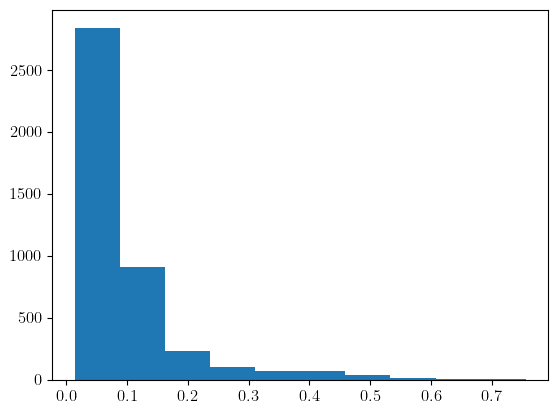

In [79]:
plt.hist(df_for_villar['redshift'])

/var/folders/2f/vnb6fr7n7g32fwlgp_k3l3sc0000gn/T/ipykernel_21995/242302293.py:1: UserWarning: cmr10 font should ideally be used with mathtext, set axes.formatter.use_mathtext to True
  plt.hist(df_for_villar['log10(SFR) [M_sol/yr]'])


(array([1.10e+01, 3.31e+03, 3.68e+02, 1.58e+02, 1.32e+02, 1.59e+02,
        1.11e+02, 1.70e+01, 3.00e+00, 5.00e+00]),
 array([-1.56789261, -1.14968172, -0.73147082, -0.31325993,  0.10495096,
         0.52316185,  0.94137275,  1.35958364,  1.77779453,  2.19600543,
         2.61421632]),
 <BarContainer object of 10 artists>)

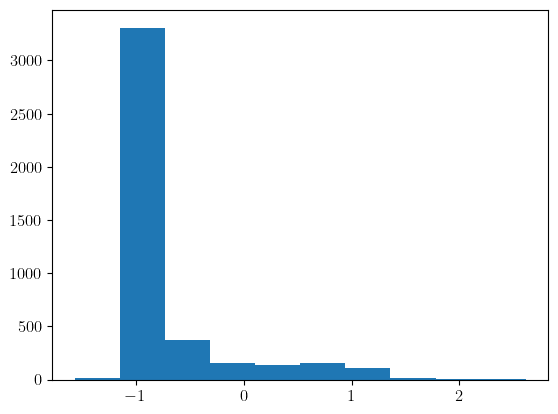

In [23]:
plt.hist(df_for_villar['log10(SFR) [M_sol/yr]'])